<!--
---
title: Handling vector data
layout: single
author: Heather Savoy
author_profile: true
header:
  overlay_color: "444444"
  overlay_image: /assets/images/margaret-weir-GZyjbLNOaFg-unsplash_dark.jpg
---
-->

**Last Update:** 28 September 2022 <br />
**Download Jupyter Notebook**: [GRWG22_VectorData.ipynb](https://geospatial.101workbook.org/tutorials/GRWG22_VectorData.ipynb)

## Overview
This tutorial covers how to manipulate geospatial vector datasets in R. A 
dataset with polygon geometries representing wildfire perimeters is joined with 
a dataset with point geometries representing air quality monitoring stations to
determine which stations observed unhealthy concentrations of small particulate 
matter (PM2.5) in the atmosphere around the time of the Camp Fire in northern CA 
in 2018.  

*Language*: `Python`

*Primary Libraries/Packages*:

|Name|Description|Link|
|-|-|-|
| geopandas | GeoPandas is an open source project to make working with geospatial data in python easier. | https://geopandas.org/en/stable/ |
| plotnine | A Grammar of Graphics for Python | https://plotnine.readthedocs.io/en/stable/ |


## Nomenclature

* *Vector data:* Spatial data defined by simple geometry types (points, lines, 
  and polygons) where each geometry feature can be assigned non-spatial attributes.
* *CRS:* Coordinate Reference System, also known as a spatial reference system. A
  system for defining geospatial coordinates.
* *Spatial join:* Combining two spatial datasets by the relationship between their
  geometries.

## Data Details

* Data: National Interagency Fire Center's Historic Perimeters dataset
* Link: [https://data-nifc.opendata.arcgis.com/datasets/nifc::historic-perimeters-combined-2000-2018-geomac/explore](https://data-nifc.opendata.arcgis.com/datasets/nifc::historic-perimeters-combined-2000-2018-geomac/explore)
* Other Details: The original dataset contains perimeters of wildfires in the US 
  from 2000-2018 as a polygon feature collection. For this tutorial, the wildfire
  perimeters in CA during 2018 were extracted. 

* Data: US EPA's Air Quality System (AQS) database
* Link: [https://aqs.epa.gov/aqsweb/documents/data_api.html](https://aqs.epa.gov/aqsweb/documents/data_api.html)
* Other Details: PM2.5 concentration data from this database covering CA in 2018 
  were retrieved and pre-processed for this tutorial. 

## Analysis Steps

  1. **[Fire perimeter data](#this_is_step1)**
    - read in and visualize the wildfire perimeter data
       - Read in geojson file
       - Visualize perimeters on map of CA
       - Visualize non-spatial attributes
  2. **[Air quality data](#step_2)**
    - read in the shapefile
  3. **[Buffer and spatial join](#step_3)**
    - find the air quality stations within 200km of the fire perimeter
  4. **[Visualize](#step_4)**
    -  air quality around the Camp Fire

### Step 0: Import Libraries / Packages

Below are commands to run to create a new Conda environment named 'geoenv' that contains the packages used in this tutorial. To learn more about using Conda environments on Ceres, see [this guide](https://scinet.usda.gov/guide/conda/).

In [ ]:
module load miniconda
conda create --name geoenv
source activate geoenv
conda install geopandas plotnine ipython

To have JupyterLab use this conda environment, we will make a kernel.


In [ ]:
ipython kernel install --user --name=geo_kernel

This tutorial assumes you are running this python notebook file in JupyterLab on 
Ceres. The easiest way to do that is with 
[Open OnDemand](http://ceres-ood.scinet.usda.gov/).  Select the following parameter 
values when requesting a Jupyter: Ceres app to be launched (all other 
values can be left to their defaults):

* `Slurm Partition`: short
* `Number of hours`: 1
* `Number of cores`: 2
* `Jupyer Notebook vs Lab`: Lab

Once you are in JupyterLab with this notebook open, select your kernel by clicking on the *Switch kernel* button in the top right corner of the editor. A pop-up will appear with a dropdown menu containing the *geo_kernel* kernel we made above. Click on the *geo_kernel* kernel and click the *Select* button. 

In [1]:
import geopandas as gpd
from plotnine import ggplot, geom_map, aes, theme, geom_histogram, scale_x_datetime, geom_line, ylab, xlab
from datetime import datetime, date

<a id='fire'></a>
### Step 1: Read in fire perimeter data and visualize

The National Interagency Fire Center's Historic Perimeters dataset has 23,776 
polygons representing wildfire perimeters from 2000-2018. A version of the dataset 
filtered to wildfires in CA in 2018, since that is when the 
destructive Camp Fire occurred, will be used in this tutorial. 

We will transform to planar coordinates for distance calculations. The 5070 EPSG
code is for the Equal Area CONUS Albers. 

In [3]:
fire_f = 'Historic_Perimeters_Combined_2000-2018_GeoMAC_CA2018.geojson'
dnld_url = 'https://raw.githubusercontent.com/ISUgenomics/geospatialworkbook/master/ExampleGeoWorkflows/assets/'
all_fires = gpd.read_file(dnld_url + fire_f)
fire_CA2018 = all_fires.to_crs(5070)

To get an idea of what the data look like, we can create a map. Since this 
feature collection has several attributes, we can also visualize, for example, 
when the fires occurred during the year.

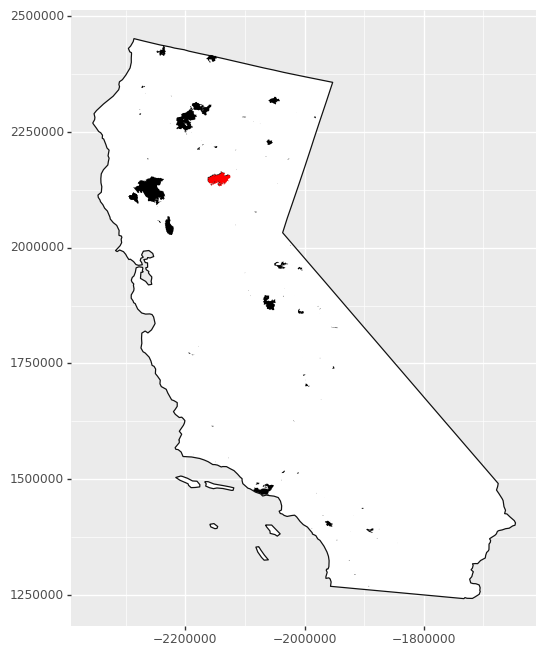

<ggplot: (419494120)>

In [5]:
# CA boundary
census_states = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_20m.zip')
CA = census_states.loc[census_states['NAME'] == 'California'].to_crs(5070)

# The Camp Fire feature
camp_fire = fire_CA2018.loc[fire_CA2018['incidentname'] == 'CAMP']

# Plot a map of all wildfires and 
# highlight the Camp Fire.
ggplot() + \
    geom_map(CA, fill = 'white') + \
    geom_map(fire_CA2018, fill = 'black', color = None) + \
    geom_map(camp_fire, fill = 'red', color = None) + \
    theme(figure_size = (6,8))


Since this feature collection has several attributes, we can also visualize, 
for example, when the fires occurred during the year.

/Users/heather.savoy/opt/anaconda3/envs/workshop/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 13'. Pick better value with 'binwidth'.


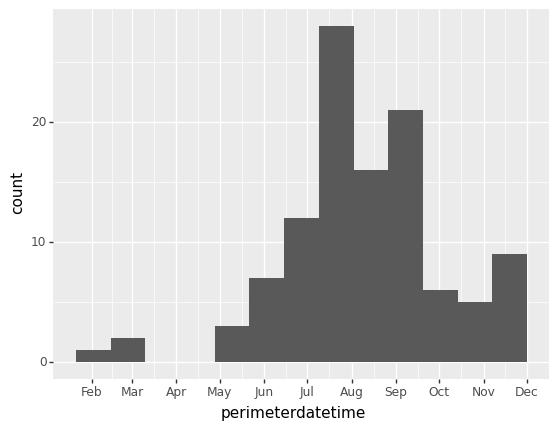

<ggplot: (431717334)>

In [11]:
# Plotting when wildfires occurred throughout 2018
ggplot(fire_CA2018, aes('perimeterdatetime')) + \
  geom_histogram() + \
  scale_x_datetime(breaks = '1 month',
                   date_labels = '%b')

<a id='air'></a>
### Step 2: Read in air quality data

We will read in an air quality dataset to showcase combining multiple vector 
datasets. The geometry type is point, representing sampling stations. This 
dataset can be downloaded with an API, but you need to register an account, so 
the download process has been done already and the data are available in our 
GitHub repository. Some pre-processing for this dataset was done to make it into 
a feature collection.

In [6]:
CA_PM25 = gpd.read_file(dnld_url + 'air_quality_CA2018.zip')

<a id='merge'></a>
### Step 3: Find the air quality stations within 200km of the fire perimeter

We will buffer the Camp Fire polygon and join that to the air quality data to 
find the nearby stations. Note that the direction of joining is important: the 
geometry of the left dataset, in this case the air quality points, will be 
retained and the attributes of intersecting features of the right dataset will 
be retained. 

In [8]:
camp_zone = camp_fire.copy()   
camp_zone['geometry'] = camp_fire.buffer(200000) # meters, buffer is in unit of CRS
air_fire = CA_PM25.sjoin(camp_zone, how="inner", predicate='intersects')

<a id='merge_plot'></a>
### Step 4: Visualize air quality around the Camp Fire

'Around' in this case should be in both space and time. We already found the 
air quality stations within 200 km from the fire perimeter. To make sure we are
looking at the right time of year, we will relate the non-spatial attributes of
the two feature collections. Both datasets come with date columns: when the air
quality was recorded and when the perimeter was determined (so the latter is 
an approximate time near the end of the fire). We will filter our spatially-
joined dataset to within 30 days of the fire perimeter date so we only consider
air quality within a 2-month window around the time of the fire. 

We can then plot the air quality metric of PM2.5 concentration (lower is better) 
as a function of time before/after the fire perimeter date. Each line is an 
individual air quality station. The figure indicates that there were several 
stations that recorded unhealthy to hazardous PM2.5 concentrations around the
time of this wildfire. 

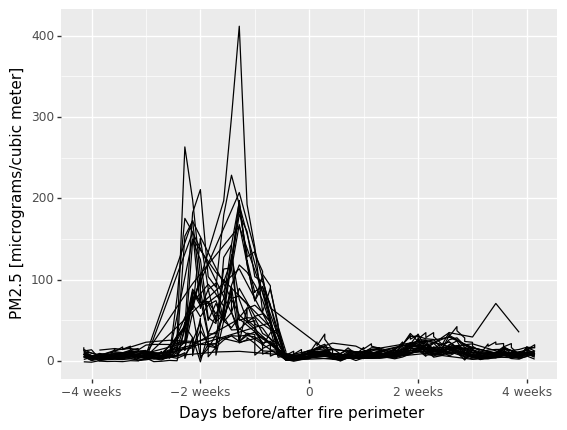

<ggplot: (419453832)>

In [9]:
# Filter to 30 days from fire perimeter date
air_fire['dat_local'] = [datetime.strptime(dt, '%Y-%m-%d').date() for dt in list(air_fire['dat_lcl'])]
air_fire['perimeterdate'] = [dt.date() for dt in air_fire['perimeterdatetime']]
air_fire['date_shift'] = air_fire['dat_local'] - air_fire['perimeterdate']
air_fire['arthmt_'] = air_fire['arthmt_'].astype('float64')
air_fire['station_id'] = air_fire['stat_cd'] + air_fire['cnty_cd'] + air_fire['st_nmbr']
air_near_fire = air_fire.loc[abs(air_fire['date_shift']).astype('timedelta64[D]') < 30]

ggplot(air_near_fire, aes('date_shift','arthmt_')) + \
  geom_line(aes(group='station_id')) + \
  xlab('Days before/after fire perimeter') + \
  ylab('PM2.5 [micrograms/cubic meter]')

We can then map where those stations were - quite an 
extensive impact on air quality!

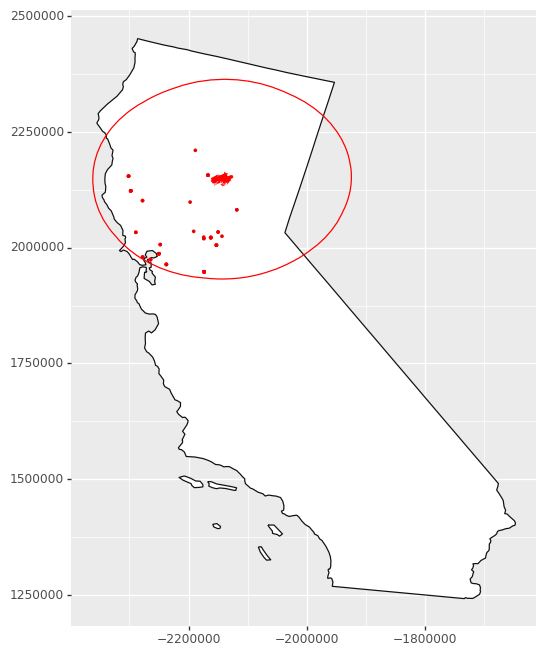

<ggplot: (431762164)>

In [12]:
# 101 micrograms/cubic meter and higher is considered
# unhealthy for sensitive groups 
unhealthy_air = air_near_fire.loc[air_near_fire['arthmt_'] > 100]

ggplot() + \
   geom_map(CA, fill = 'white') + \
   geom_map(camp_zone, fill = None, color = 'red') + \
   geom_map(camp_fire, fill = 'red', color = None) + \
   geom_map(unhealthy_air, color = 'red') + \
   theme(figure_size = (6,8))
